Code for discussion on [Pymc 9496](https://discourse.pymc.io/t/marginal-likelihood-for-distributions-with-discrete-variables/9469)

By pymc user BrendaH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.figure_factory as ff
import os
import pymc3 as pm
import arviz as az
import warnings
import os
import theano
import theano.tensor as T
import pymc3 as pm
from pymc3.model import modelcontext
from scipy import dot
from scipy.linalg import cholesky as chol
import warnings
import seaborn as sns
import scipy.stats as st
import theano.tensor as tt
%pylab inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 0 : Data Simulation

In [2]:
# function of three trajectories
def f1(t):
    return t

def f2(t):
    return 3*t

def f3(t):
    return 6*t

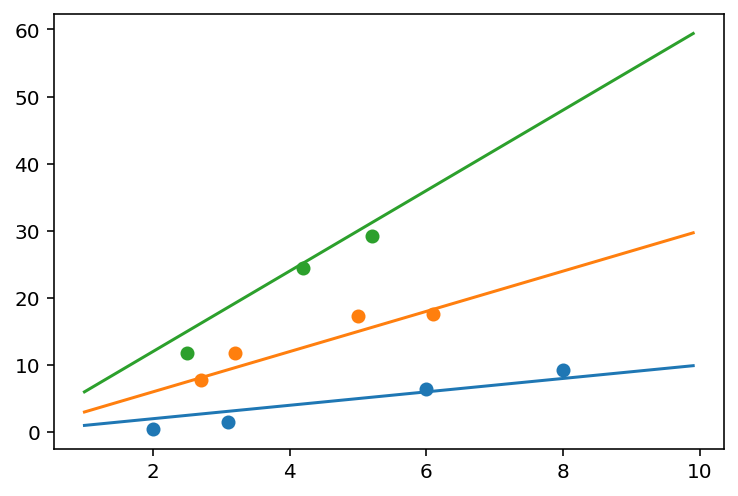

In [3]:
# generate simulated data 
t = np.arange(1,10,0.1)
plt.plot(t,f1(t))
plt.plot(t,f2(t))
plt.plot(t,f3(t))
t1s = np.array([2.,3.1,6.,8.])
t2s = np.array([3.2,2.7,5.,6.1])
t3s = np.array([2.5,4.2,5.2])

y1s = t1s + np.random.normal(0,2,len(t1s))
y2s = 3*t2s + np.random.normal(0,2,len(t2s))
y3s = 6*t3s + np.random.normal(0,2,len(t3s))

plt.scatter(t1s,y1s)
plt.scatter(t2s,y2s)
plt.scatter(t3s,y3s)

In [4]:
nsubs = len(t1s) + len(t2s) + len(t3s)
ts = np.array(list(t1s)+list(t2s)+list(t3s))
ys_obs = np.array(list(y1s)+list(y2s)+list(y3s))

## Part 1: Model with discrete latent variable called category

In [5]:
import pymc3 as pm
import theano
import theano.tensor as T

with pm.Model() as model:
    # the ratio of samples in each subtype
    subtype = 3
    p = pm.Dirichlet("p", a=np.ones(subtype), shape= subtype)
    # latent cluster of each observation
    category = pm.Categorical("category", p=p,shape = nsubs )
    sigma = pm.Normal("sigma", 1)

    fs = np.zeros([subtype,len(ts)])
    fs[0] = f1(ts)
    fs[1] = f2(ts)
    fs[2] = f3(ts)
    fs = T.as_tensor_variable(fs)

    for i in range(nsubs):
        Y = pm.Normal("Y"+str(i), mu= fs[category[i],i], sigma=sigma, observed= ys_obs[i])
    if subtype >2:
        step0 = pm.CategoricalGibbsMetropolis(vars=[category])
    else:
        step0 = pm.BinaryGibbsMetropolis(vars=[category])
    step1 = pm.Metropolis(vars = [p,sigma])
    trace = pm.sample(1000, tune= 6000, cores=4,chains =1, step=[step0,step1])

Sequential sampling (1 chains in 1 job)
CompoundStep
>CategoricalGibbsMetropolis: [category]
>CompoundStep
>>Metropolis: [sigma]
>>Metropolis: [p]


Sampling 1 chain for 6_000 tune and 1_000 draw iterations (6_000 + 1_000 draws total) took 17 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [6]:
df_summary = pm.summary(trace)
df_summary

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
category[0],0.019,0.137,0.000,0.000,0.007,0.005,408.0,408.0,NaN
category[1],0.003,0.055,0.000,0.000,0.002,0.002,601.0,601.0,NaN
category[2],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
category[3],0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
category[4],1.001,0.032,1.000,1.000,0.001,0.001,1004.0,1004.0,NaN
category[5],0.942,0.234,1.000,1.000,0.014,0.010,299.0,299.0,NaN
category[6],1.000,0.000,1.000,1.000,0.000,0.000,1000.0,1000.0,NaN
category[7],0.999,0.032,1.000,1.000,0.001,0.001,1004.0,1000.0,NaN
category[8],1.674,0.471,1.000,2.000,0.031,0.022,227.0,233.0,NaN
category[9],2.000,0.000,2.000,2.000,0.000,0.000,1000.0,1000.0,NaN


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


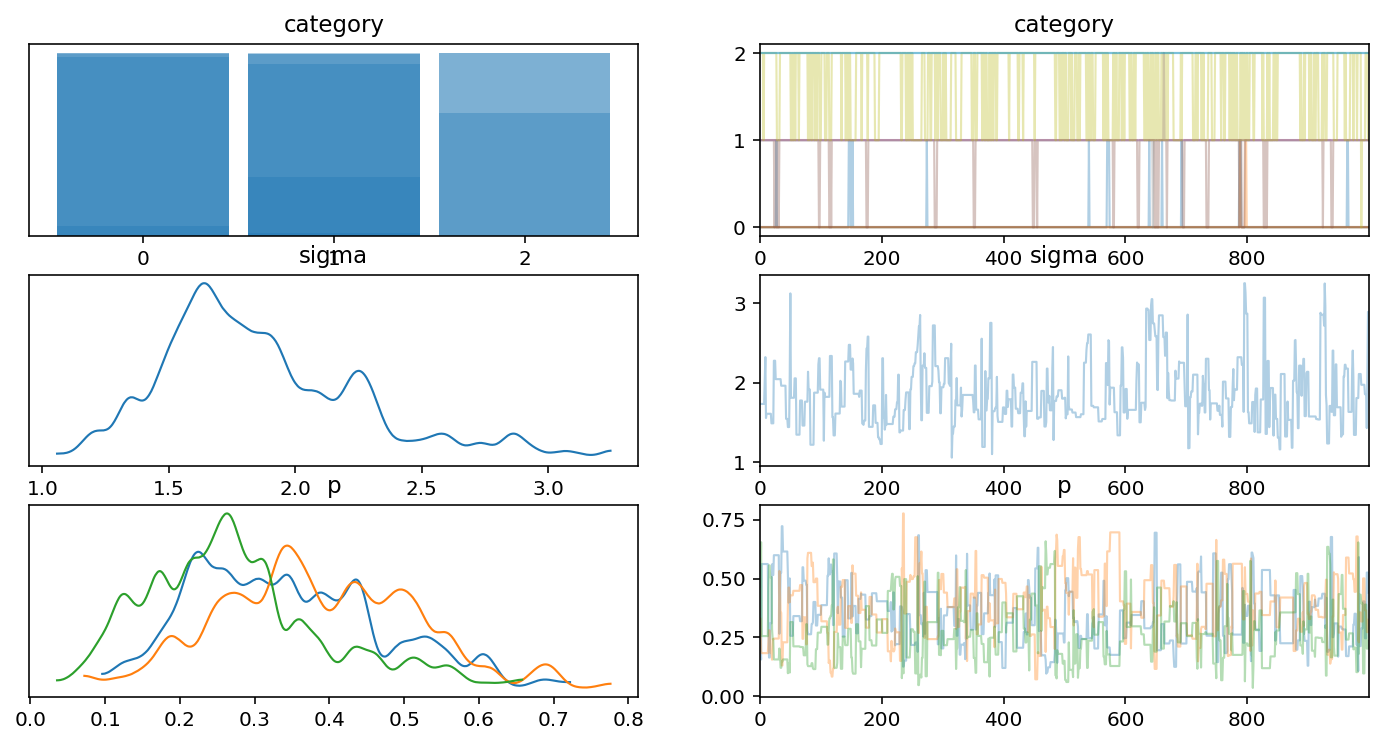

In [7]:
import arviz as az
import matplotlib.pyplot as plt
az.rcParams["plot.max_subplots"] = 100
pm.traceplot(trace);

## Part2: Marginalize out latent discrete variable with pm.Mixture

### Question 1: 

Is the for loop + pm.Mixture a correct way to marginalize the model with discrete latent variable? 

Any other more efficient ways to do this?

In [8]:
import pymc3 as pm
import theano
import theano.tensor as T

with pm.Model() as model:
    # the ratio of samples in each subtype
    subtype = 3
    p = pm.Dirichlet("p", a=np.ones(subtype), shape= subtype)

    sigma = pm.Normal("sigma", 1)
    ts = np.array(list(t1s)+list(t2s)+list(t3s))
    fs = np.zeros([subtype,len(ts)])
    fs[0] = f1(ts)
    fs[1] = f2(ts)
    fs[2] = f3(ts)
    fs = T.as_tensor_variable(fs)
 
    for i in range(nsubs):
        comp_dists = pm.Normal.dist(mu=fs[:,i], sigma = sigma, shape = (subtype,))
        Y = pm.Mixture("Y"+str(i), w = p, comp_dists = comp_dists, observed= ys_obs[i])
    step1 = pm.Metropolis()
    trace = pm.sample(1000, tune= 6000, cores=4,chains =1, step=[step1])
    #trace = pm.sample_smc(1000, cores=4,chains =1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p]


Sampling 1 chain for 6_000 tune and 1_000 draw iterations (6_000 + 1_000 draws total) took 5 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [9]:
model_margin = model
trace_margin = trace

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


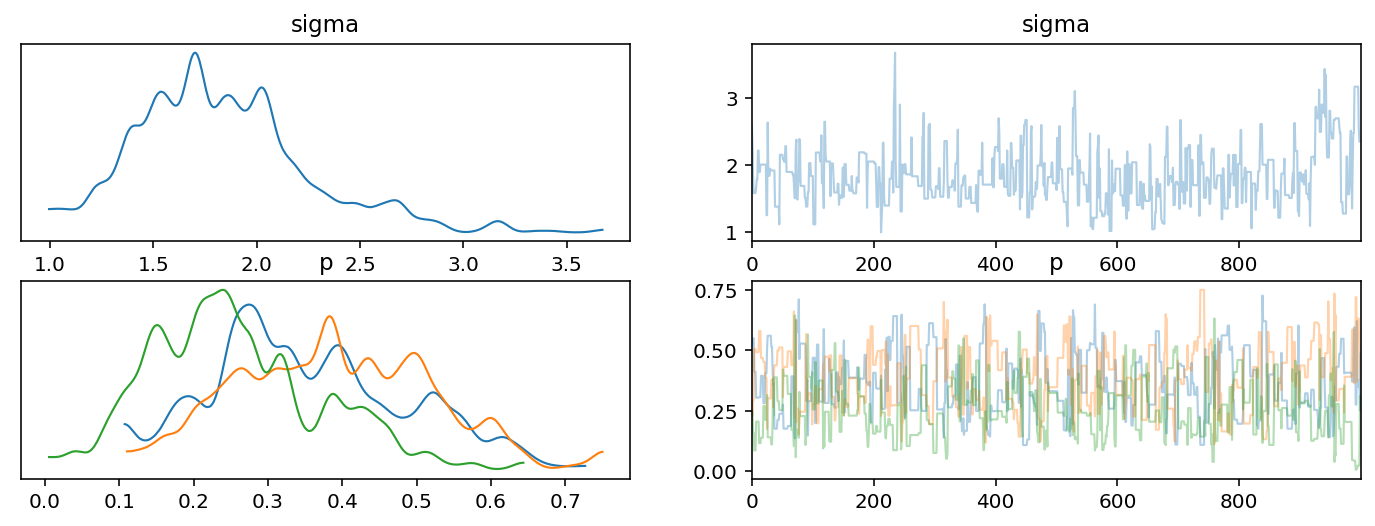

In [10]:
import arviz as az
import matplotlib.pyplot as plt
az.rcParams["plot.max_subplots"] = 100
pm.traceplot(trace_margin);

In [11]:
df_summary = pm.summary(trace_margin)
df_summary

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.834,0.414,1.190,2.697,0.043,0.034,113.0,48.0,NaN
p[0],0.357,0.129,0.155,0.621,0.012,0.008,123.0,170.0,NaN
p[1],0.389,0.128,0.163,0.609,0.012,0.009,118.0,164.0,NaN
p[2],0.254,0.113,0.083,0.473,0.011,0.008,106.0,173.0,NaN


## Part3: Bridge Sampling using the marginalized model
Original Code from [Junpeng Lao](https://junpenglao.xyz/Blogs/posts/2017-11-22-Marginal_likelihood_in_PyMC3.html)


In [12]:
model_margin.free_RVs

[p_stickbreaking__ ~ TransformedDistribution, sigma ~ Normal]

### Question 2:

How do deal with the transformed distribution and the change of the variable name obtained from p to p_stickbreaking__ form model_margin.free_RVs?

I manually change the name back by writing 

```
if var.name == 'p_stickbreaking__':
    neff_list.append(float(np.mean(pm.ess(mtrace[N1_:],var_names=['p'])['p'])))
```
But not sure if it's correct.
Besides, I also met other similar tranformation before (not in this code) when using 

`k = pm.Uniform('k',0,10,shape = 3)` I got:
```
k_interval__ ~ TransformedDistribution
```
I'm wondering how to deal with such kind of transformation generally (not limited to stickbreaking__ or interval__)?

### Question3: 

Some functions in the original Bridge sampling code is out of date. I did some modifications. Are they correct?

Original Version:

```
for var in vars:
    varmap = model.bijection.ordering.by_name[var.name]
    # for fitting the proposal
    x = mtrace[:N1_][var.name]
    samples_4_fit[varmap.slc, :] = x.reshape((x.shape[0],np.prod(x.shape[1:], dtype=int))).T
    # for the iterative scheme
    x2 = mtrace[N1_:][var.name]
    samples_4_iter[varmap.slc, :] = x2.reshape((x2.shape[0], np.prod(x2.shape[1:], dtype=int))).T
    # effective sample size of samples_4_iter, scalar
    neff_list.update(pm.effective_n(mtrace[N1_:],varnames=[var.name]))

# median effective sample size (scalar)
neff = pm.stats.dict2pd(neff_list,'temp').median()
```
Modified Version:
```
for var in vars:
    varmap = model.bijection.ordering.by_name[var.name]
    # for fitting the proposal
    x = mtrace[:N1_][var.name]
    samples_4_fit[varmap.slc, :] = x.reshape((x.shape[0],np.prod(x.shape[1:], dtype=int))).T
    # for the iterative scheme
    x2 = mtrace[N1_:][var.name]
    samples_4_iter[varmap.slc, :] = x2.reshape((x2.shape[0], np.prod(x2.shape[1:], dtype=int))).T

    # effective sample size of samples_4_iter, scalar

            #################################
            ### Below have been modified: ###

    # effective sample size of samples_4_iter, scalar

    if var.name == 'p_stickbreaking__':
        neff_list.append(float(np.mean(pm.ess(mtrace[N1_:],var_names=['p'])['p'])))
    else:
        neff_list.append(float(pm.ess(mtrace[N1_:],var_names=[var.name])[var.name]))

# median effective sample size (scalar)
neff = median(neff_list)
         
```


### Full Modified code:

In [13]:
# Based on https://github.com/quentingronau/bridgesampling/blob/master/R/bridge_sampler_normal.
# Original Code From Junpeng Lao https://junpenglao.xyz/Blogs/posts/2017-11-22-Marginal_likelihood_in_PyMC3.html

def Marginal_llk(mtrace, model=None, logp=None, maxiter=1000):
    """The Bridge Sampling Estimator of the Marginal Likelihood.

    Parameters
    ----------
    mtrace : MultiTrace, result of MCMC run
    model : PyMC Model
        Optional model. Default None, taken from context.
    logp : Model Log-probability function, read from the model by default
    maxiter : Maximum number of iterations

    Returns
    -------
    marg_llk : Estimated Marginal log-Likelihood.
    """
    r0, tol1, tol2 = 0.5, 1e-10, 1e-4

    model = modelcontext(model)
    if logp is None:
        logp = model.logp_array
    vars = model.free_RVs

    # Split the samples into two parts  
    # Use the first 50% for fiting the proposal distribution and the second 50% 
    # in the iterative scheme.
    len_trace = len(mtrace)
    nchain = mtrace.nchains
    
    N1_ = len_trace // 2
    N1 = N1_*nchain
    N2 = len_trace*nchain - N1

    #neff_list = dict() # effective sample size
    neff_list = []
    arraysz = model.bijection.ordering.size
    samples_4_fit = np.zeros((arraysz, N1))
    samples_4_iter = np.zeros((arraysz, N2))
    # matrix with already transformed samples
    for var in vars:
        varmap = model.bijection.ordering.by_name[var.name]
        # for fitting the proposal
        x = mtrace[:N1_][var.name]
        samples_4_fit[varmap.slc, :] = x.reshape((x.shape[0], 
                                                  np.prod(x.shape[1:], dtype=int))).T
        # for the iterative scheme
        x2 = mtrace[N1_:][var.name]
        samples_4_iter[varmap.slc, :] = x2.reshape((x2.shape[0], 
                                                    np.prod(x2.shape[1:], dtype=int))).T
        # effective sample size of samples_4_iter, scalar
        #neff_list.update(pm.effective_n(mtrace[N1_:],varnames=[var.name]))
        #neff_list.append(float(pm.ess(mtrace[N1_:],var_names=[var.name])[var.name]))
        if var.name == 'p_stickbreaking__':
            neff_list.append(float(np.mean(pm.ess(mtrace[N1_:],var_names=['p'])['p'])))
        else:
            neff_list.append(float(pm.ess(mtrace[N1_:],var_names=[var.name])[var.name]))
    # median effective sample size (scalar)
    neff = median(neff_list)#pm.ess(mtrace[N1_:],var_names=[var.name],method = 'median')[var.name] #pm.stats.dict2pd(neff_list,'temp').median()
        
    # get mean & covariance matrix and generate samples from proposal
    m = np.mean(samples_4_fit, axis=1)
    V = np.cov(samples_4_fit)
    L = chol(V, lower=True)

    # Draw N2 samples from the proposal distribution
    gen_samples = m[:, None] + dot(L, st.norm.rvs(0, 1, 
                                         size=samples_4_iter.shape))

    # Evaluate proposal distribution for posterior & generated samples
    q12 = st.multivariate_normal.logpdf(samples_4_iter.T, m, V)
    q22 = st.multivariate_normal.logpdf(gen_samples.T, m, V)

    # Evaluate unnormalized posterior for posterior & generated samples
    q11 = np.asarray([logp(point) for point in samples_4_iter.T])
    q21 = np.asarray([logp(point) for point in gen_samples.T])

    # Iterative scheme as proposed in Meng and Wong (1996) to estimate
    # the marginal likelihood
    def iterative_scheme(q11, q12, q21, q22, r0, neff, tol, maxiter, criterion):
        l1 = q11 - q12
        l2 = q21 - q22
        lstar = np.median(l1) # To increase numerical stability, 
                              # subtracting the median of l1 from l1 & l2 later
        s1 = neff/(neff + N2)
        s2 = N2/(neff + N2)
        r = r0
        r_vals = [r]
        logml = np.log(r) + lstar
        criterion_val = 1 + tol

        i = 0
        while (i <= maxiter) & (criterion_val > tol):
            rold = r
            logmlold = logml
            numi = np.exp(l2 - lstar)/(s1 * np.exp(l2 - lstar) + s2 * r)
            deni = 1/(s1 * np.exp(l1 - lstar) + s2 * r)
            if np.sum(~np.isfinite(numi))+np.sum(~np.isfinite(deni)) > 0:
                warnings.warn("""Infinite value in iterative scheme, returning NaN. 
                Try rerunning with more samples.""")
            r = (N1/N2) * np.sum(numi)/np.sum(deni)
            r_vals.append(r)
            logml = np.log(r) + lstar
            i += 1
            if criterion=='r':
                criterion_val = np.abs((r - rold)/r)
            elif criterion=='logml':
                criterion_val = np.abs((logml - logmlold)/logml)

        if i >= maxiter:
            return dict(logml = np.NaN, niter = i, r_vals = np.asarray(r_vals))
        else:
            return dict(logml = logml, niter = i)

    # Run iterative scheme:
    tmp = iterative_scheme(q11, q12, q21, q22, r0, neff, tol1, maxiter, 'r')
    if ~np.isfinite(tmp['logml']):
        warnings.warn("""logml could not be estimated within maxiter, rerunning with 
                      adjusted starting value. Estimate might be more variable than usual.""")
        # use geometric mean as starting value
        r0_2 = np.sqrt(tmp['r_vals'][-2]*tmp['r_vals'][-1])
        tmp = iterative_scheme(q11, q12, q21, q22, r0_2, neff, tol2, maxiter, 'logml')

    return dict(logml = tmp['logml'], niter = tmp['niter'], method = "normal", 
                q11 = q11, q12 = q12, q21 = q21, q22 = q22)

In [14]:
logml_dict = Marginal_llk(trace, model=model_margin, maxiter=1000)
print('The Bridge Sampling Estimatation is %.5f'%((logml_dict['logml'])))

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


The Bridge Sampling Estimatation is -36.11901


## Part4: SMC with marginalized model - fail

### Question 4: why SMC fail?
Note: Currently using pymc3 since I have some issue importing pymc4. Will try later.


In [15]:
import pymc3 as pm
import theano
import theano.tensor as T

with pm.Model() as model:
    # the ratio of samples in each subtype
    subtype = 3
    p = pm.Dirichlet("p", a=np.ones(subtype), shape= subtype)

    sigma = pm.Normal("sigma", 1)
    ts = np.array(list(t1s)+list(t2s)+list(t3s))
    fs = np.zeros([subtype,len(ts)])
    fs[0] = f1(ts)
    fs[1] = f2(ts)
    fs[2] = f3(ts)
    fs = T.as_tensor_variable(fs)
 
    for i in range(nsubs):
        comp_dists = pm.Normal.dist(mu=fs[:,i], sigma = sigma, shape = (subtype,))
        Y = pm.Mixture("Y"+str(i), w = p, comp_dists = comp_dists, observed= ys_obs[i])
    step1 = pm.Metropolis()
    #trace = pm.sample(1000, tune= 6000, cores=4,chains =1, step=[step1])
    trace = pm.sample_smc(1000, cores=4,chains =1)

Initializing SMC sampler...
Sampling 1 chain in 1 job


ValueError: ignored